In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [14]:
import os

import tensorflow as tf
import numpy as np

SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)  

In [15]:
cwd = os.getcwd()

# ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

In [16]:
from PIL import Image

from read_mask_example import read_rgb_mask

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'valid.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.jpg'))
    mask = Image.fromarray(read_rgb_mask(os.path.join(self.dataset_dir, 'Masks/', curr_filename + '.png')))

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds 
    # to the contours of the objects. We remove it for simplicity.
    #mask_arr[mask_arr == 255] = 0

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [17]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 256
img_w = 256

num_classes = 3
dataset_dir = 'D:/OneDrive - Politecnico di Milano/Corsi/2 Anno - 1 Sem/Artificial Neural Networks and Deep Learning/Homework/NNDL/Development_Dataset/Training/Bipbip/Haricot/'


# Set preprocess_input = None to display original image
dataset = CustomDataset(dataset_dir, 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset(dataset_dir, 'validation', 
                              preprocessing_function=preprocess_input)


In [18]:
bs = 8 # batch size

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [19]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, num_classes)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


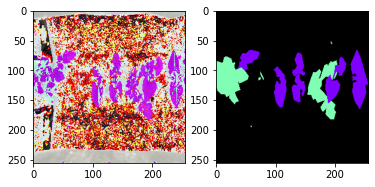

In [20]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes + 1):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [21]:
# Encoder
encoder = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

finetuning = False

if finetuning:
    freeze_until = 15 # layer from which we want to fine-tune
    
    for layer in encoder.layers[:freeze_until]:
        layer.trainable = False
else:
    encoder.trainable = False
    for layer in encoder.layers:
        encoder.trainable = False

encoder.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [22]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    model.add(encoder)
    
    start_f = 256
        
    # Decoder
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    model.add(tf.keras.layers.Conv2D(filters=num_classes+1,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model
    

model = create_model(depth=5, start_f=8, num_classes=num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       1179904   
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 128)       0

In [23]:
# Optimization params

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1, num_classes + 1): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]
# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [24]:
# Callbacks
callbacks = []

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    callbacks.append(es_callback)

In [ ]:
# Fit the model
model.fit(x=train_dataset,
          epochs=1,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid),
          callbacks=callbacks)

In [ ]:
model.save('model_baseline_bipbip_haricot1')

In [25]:
model = tf.keras.models.load_model('model_baseline_bipbip_haricot1', {'meanIoU': meanIoU})

In [26]:
# Compute predictions

from os import listdir
from os.path import isfile, join, basename, splitext

# CustomTestDataset to load test images
# Specify the full path to the folder containing the images
class CustomTestDataset(tf.keras.utils.Sequence):

    def __init__(self, dataset_dir, img_generator=None, 
              preprocessing_function=None, out_shape=[256, 256]):

      subset_filenames = [splitext(basename(f))[0] for f in 
                                                listdir(dataset_dir) if isfile(join(dataset_dir, f))]

      self.dataset_dir = dataset_dir
      self.subset_filenames = subset_filenames
      self.img_generator = img_generator
      self.preprocessing_function = preprocessing_function
      self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + '.jpg'))

        # Resize image and mask
        img = img.resize(self.out_shape)

        img_arr = np.array(img)

        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)

        return img_arr

    def get_name(self, index):
        return self.subset_filenames[index]

In [58]:
from prepare_submission import rle_encode
import json

test_dir = 'D:/OneDrive - Politecnico di Milano/Corsi/2 Anno - 1 Sem/Artificial Neural Networks and Deep Learning/Homework/NNDL/Development_Dataset/Test_Dev/Bipbip/Haricot/Images'

test_dataset = CustomTestDataset(test_dir, preprocessing_function=preprocess_input)

submission_dict = {}

for i in range(test_dataset.__len__()):
    image = test_dataset.__getitem__(i)
    img_name = test_dataset.get_name(i)

    prediction = model.predict(tf.expand_dims(image, axis=0))
    mask_arr = tf.argmax(prediction, -1)[0, ...] # (256, 256)
    mask_arr = np.array(mask_arr)

    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = mask_arr.shape
    submission_dict[img_name]['team'] = 'Bipbip'
    submission_dict[img_name]['crop'] = 'Haricot'
    submission_dict[img_name]['segmentation'] = {}

    rle_encoded_crop = rle_encode(mask_arr == 1)
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

In [59]:
# empty submission for other datasets
def empty_submission(team, crop, dir):
    images_dir = join(dir, team, crop, 'Images')
    images_name = [splitext(basename(f))[0] for f in listdir(images_dir) if isfile(join(images_dir, f))]
    
    res = {}
    for img_name in images_name:
        res[img_name] = {}
        res[img_name]['shape'] = [256, 256]
        res[img_name]['team'] = team
        res[img_name]['crop'] = crop
        res[img_name]['segmentation'] = {} 
        res[img_name]['segmentation']['crop'] = ""
        res[img_name]['segmentation']['weed'] = ""

    return res

dir = r'D:\OneDrive - Politecnico di Milano\Corsi\2 Anno - 1 Sem\Artificial Neural Networks and Deep Learning\Homework\NNDL\Development_Dataset\Test_Dev'
submission_dict.update(empty_submission('Bipbip', 'Mais', dir))
submission_dict.update(empty_submission('Pead', 'Haricot', dir))
submission_dict.update(empty_submission('Pead', 'Mais', dir))
submission_dict.update(empty_submission('Roseau', 'Haricot', dir))
submission_dict.update(empty_submission('Roseau', 'Mais', dir))
submission_dict.update(empty_submission('Weedelec', 'Haricot', dir))
submission_dict.update(empty_submission('Weedelec', 'Mais', dir))

with open('./submission.json', 'w') as f:
    json.dump(submission_dict, f)